<a href="https://colab.research.google.com/github/dudaholandah/NLP/blob/main/Projeto/Word2Vec_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!cp -r '/content/drive/MyDrive/Datasets/cuisine-classification-ingredients' 'cuisine-classification-ingredients'

In [3]:
!cp -r '/content/drive/MyDrive/Datasets/indian-food' 'indian-food'

# Imports

In [ ]:
!pip install gensim --upgrade
!pip install keras
!pip install tensorflow
!pip install keras-tuner --upgrade

In [ ]:
#WORD2VEC
from gensim.models import Word2Vec
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
#Neural Network
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,Activation,SimpleRNN,Dropout,Masking,LSTM
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from keras_tuner import HyperModel
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#Data
import json
import os
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# Data

## Download

### Cuisine Classification Data

In [232]:
path = 'cuisine-classification-ingredients/train.json'

with open(path, 'r') as f:
  json_file = json.load(f)

In [233]:
df_cuisine = pd.DataFrame(json_file, columns=['id', 'cuisine', 'ingredients'])

In [234]:
df_cuisine = df_cuisine.drop(['id'], axis=1)

In [235]:
df_cuisine = df_cuisine[:10000]

In [236]:
df_cuisine.head(5)

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."


### Indian Food Data

In [237]:
path = 'indian-food/indian_food.csv'
df_indian = pd.read_csv(path)

In [238]:
df_indian.head(5)

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40,sweet,dessert,West Bengal,East


## Pre-Processing

In [239]:
def pre_processing(text):
  new = ""
  for word in text.split(','):
    word = re.sub(r'[^\w\s]', '', word.lower())
    word = re.sub(r'[0-9]+', '', word)
    word = re.sub(r'\boz\b', '', word)
    word = re.sub(r'\ba taste of\b', '', word)
    new = new + word.strip() + " "

  return new[:-1]

### Cuisine Classification Data

In [240]:
df_cuisine['ingredients'] = [','.join(x).strip() for x in df_cuisine['ingredients']]

In [241]:
df_cuisine['ingredients'] = [pre_processing(x) for x in df_cuisine['ingredients']]

In [242]:
X = df_cuisine['ingredients']
y = df_cuisine['cuisine']

# dados de teste = 20% do treinamento
X_train_cuisine, X_test_cuisine, y_train_cuisine, y_test_cuisine = train_test_split(X, y, test_size=0.2)

# dados de validacao = 50% do teste
X_test_cuisine, X_valid_cuisine, y_test_cuisine, y_valid_cuisine = train_test_split(X, y, test_size=0.5)

In [243]:
y_train_cuisine = pd.Categorical(y_train_cuisine)
y_train_int_cuisine = y_train_cuisine.codes

y_valid_cuisine = pd.Categorical(y_valid_cuisine)
y_valid_int_cuisine = y_valid_cuisine.codes

y_test_cuisine = pd.Categorical(y_test_cuisine)
target_names_cuisine = y_test_cuisine.categories
y_test_int_cuisine = y_test_cuisine.codes

y_train_cuisine = to_categorical(y_train_int_cuisine)
y_valid_cuisine = to_categorical(y_valid_int_cuisine)
y_test_cuisine = to_categorical(y_test_int_cuisine)

### Indian Food Data

In [244]:
df_indian['ingredients'] = [pre_processing(x) for x in df_indian['ingredients']]

In [245]:
X = df_indian['ingredients']
y = df_indian['diet']

# dados de teste = 20% do treinamento
X_train_indian, X_test_indian, y_train_indian, y_test_indian = train_test_split(X, y, test_size=0.2)

# dados de validacao = 50% do teste
X_test_indian, X_valid_indian, y_test_indian, y_valid_indian = train_test_split(X, y, test_size=0.5)

In [246]:
y_train_indian = pd.Categorical(y_train_indian)
y_train_int_indian = y_train_indian.codes

y_valid_indian = pd.Categorical(y_valid_indian)
y_valid_int_indian = y_valid_indian.codes

y_test_indian = pd.Categorical(y_test_indian)
target_names_indian = y_test_indian.categories
y_test_int_indian = y_test_indian.codes

y_train_indian = to_categorical(y_train_int_indian)
y_valid_indian = to_categorical(y_valid_int_indian)
y_test_indian = to_categorical(y_test_int_indian)

# Word2Vec

In [271]:
def create_embedding_matrix(tokenizer, model, vocab_size, embedding_dim):
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, i in tokenizer.word_index.items():
    if word in model.wv:
      embedding_matrix[i] = model.wv.get_vector(word)
    else:
      embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25), embedding_dim)
  return embedding_matrix

### Cuisine Classification Data

In [272]:
EMBEDDING_DIM = 100
MAX_LENGTH_C = 50

In [273]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_cuisine)
vocab_size_cuisine = len(tokenizer.word_index) + 1

In [274]:
# Train Data
encoded_cuisine = tokenizer.texts_to_sequences(X_train_cuisine)
X_train_cuisine_padded = pad_sequences(encoded_cuisine, maxlen=MAX_LENGTH_C, padding='post', truncating='post')

# Valid Data
encoded_cuisine = tokenizer.texts_to_sequences(X_valid_cuisine)
X_valid_cuisine_padded = pad_sequences(encoded_cuisine, maxlen=MAX_LENGTH_C, padding='post', truncating='post')

# Test Data
encoded_cuisine = tokenizer.texts_to_sequences(X_test_cuisine)
X_test_cuisine_padded = pad_sequences(encoded_cuisine, maxlen=MAX_LENGTH_C, padding='post', truncating='post')

In [275]:
# EMBEDDING LAYER

ingredients = '. '.join(X_train_cuisine)
sentences = nltk.sent_tokenize(ingredients)

sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
model_word2vec = Word2Vec(sentences, vector_size=EMBEDDING_DIM, min_count=1, window=5, sg=1,workers=4)

embedding_matrix_cuisine = create_embedding_matrix(tokenizer, model_word2vec, vocab_size_cuisine, EMBEDDING_DIM)

In [276]:
embedding_matrix_cuisine.shape

(2151, 100)

### Indian Food Data

In [286]:
EMBEDDING_DIM = 100
MAX_LENGTH_I = 12

In [287]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_indian)
vocab_size_indian = len(tokenizer.word_index) + 1

In [288]:
# Train Data
encoded_indian = tokenizer.texts_to_sequences(X_train_indian)
X_train_indian_padded = pad_sequences(encoded_indian, maxlen=MAX_LENGTH_I, padding='post', truncating='post')

# Validation Data
encoded_indian = tokenizer.texts_to_sequences(X_valid_indian)
X_valid_indian_padded = pad_sequences(encoded_indian, maxlen=MAX_LENGTH_I, padding='post', truncating='post')

# Test Data
encoded_indian = tokenizer.texts_to_sequences(X_test_indian)
X_test_indian_padded = pad_sequences(encoded_indian, maxlen=MAX_LENGTH_I, padding='post', truncating='post')

In [289]:
# EMBEDDING LAYER

ingredients = '. '.join(X_train_indian)
sentences = nltk.sent_tokenize(ingredients)

sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
model_word2vec = Word2Vec(sentences, vector_size=EMBEDDING_DIM, min_count=1, window=5, sg=1,workers=4)

embedding_matrix_indian = create_embedding_matrix(tokenizer, model_word2vec, vocab_size_indian, EMBEDDING_DIM)

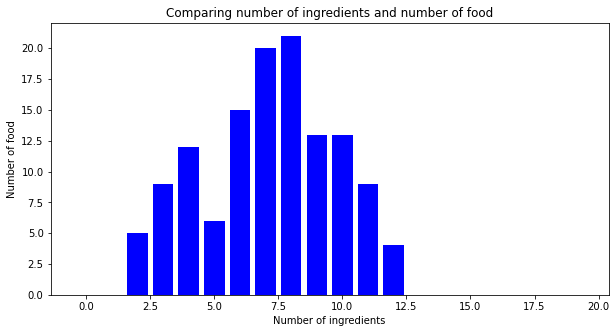

In [290]:
max_ingredients = 20

hist = {}

hist['qtde'] = [x for x in range(0,max_ingredients)]

lista = [0]*(max_ingredients)
for x in encoded_indian:
    lista[len(x)]+=1

hist['num food'] = lista
fig = plt.figure(figsize = (10, 5))
 
plt.bar(hist['qtde'],hist['num food'],
        color ='blue')
 
plt.xlabel("Number of ingredients")
plt.ylabel("Number of food")
plt.title("Comparing number of ingredients and number of food")
plt.show()

# CNN

In [282]:
class CNNHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=6, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### Cuisine Classification Data

In [291]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM, weights=[embedding_matrix_cuisine], input_length=MAX_LENGTH_C, trainable=False)

In [292]:
model_CNN = CNNHyperModel(embedding_layer, 20)

In [293]:
model_cuisine = model_CNN.build(0)

In [294]:
model_cuisine.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 50, 100)           215100    
                                                                 
 conv1d_18 (Conv1D)          (None, 45, 128)           76928     
                                                                 
 dropout_13 (Dropout)        (None, 45, 128)           0         
                                                                 
 global_max_pooling1d_19 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_60 (Dense)            (None, 128)               16512     
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                     

In [295]:
history_fine = model_cuisine.fit(X_train_cuisine_padded,y_train_cuisine,validation_data=(X_valid_cuisine_padded,y_valid_cuisine), epochs=100) 

Epoch 1/100
250/250 [==============================] - 6s 21ms/step - loss: 2.3551 - accuracy: 0.3394 - val_loss: 2.2708 - val_accuracy: 0.4648
Epoch 2/100
250/250 [==============================] - 5s 20ms/step - loss: 1.8191 - accuracy: 0.4946 - val_loss: 1.9663 - val_accuracy: 0.5426
Epoch 3/100
250/250 [==============================] - 5s 20ms/step - loss: 1.5652 - accuracy: 0.5379 - val_loss: 1.7510 - val_accuracy: 0.5612
Epoch 4/100
250/250 [==============================] - 5s 20ms/step - loss: 1.4494 - accuracy: 0.5595 - val_loss: 1.6920 - val_accuracy: 0.5740
Epoch 5/100
250/250 [==============================] - 5s 20ms/step - loss: 1.3842 - accuracy: 0.5716 - val_loss: 1.6005 - val_accuracy: 0.5976
Epoch 6/100
250/250 [==============================] - 7s 27ms/step - loss: 1.3326 - accuracy: 0.5916 - val_loss: 1.5488 - val_accuracy: 0.6126
Epoch 7/100
250/250 [==============================] - 5s 20ms/step - loss: 1.2980 - accuracy: 0.5965 - val_loss: 1.4962 - val_accuracy:

In [296]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [297]:
y_prob = model_cuisine.predict(X_test_cuisine_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.81      0.79      0.80        72
     british       0.58      0.89      0.70        91
cajun_creole       0.94      0.94      0.94       215
     chinese       0.95      0.93      0.94       321
    filipino       0.95      0.80      0.87       103
      french       0.82      0.87      0.85       342
       greek       0.92      0.86      0.89       150
      indian       0.92      0.97      0.95       355
       irish       0.79      0.74      0.77        84
     italian       0.96      0.94      0.95       963
    jamaican       0.92      0.76      0.83        71
    japanese       0.85      0.88      0.86       183
      korean       0.91      0.90      0.91       115
     mexican       0.96      0.97      0.97       813
    moroccan       0.95      0.84      0.89        97
     russian       0.73      0.67      0.70        60
 southern_us       0.94      0.91      0.92       540
     spanish       0.94    

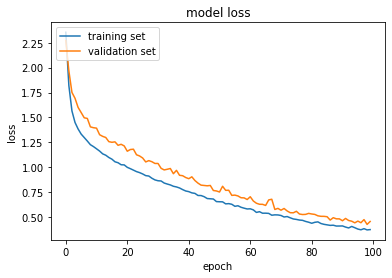

In [298]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

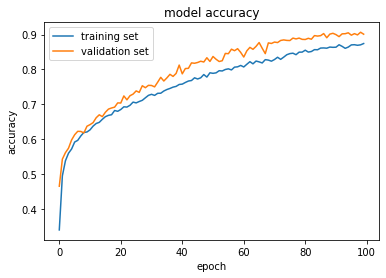

In [299]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

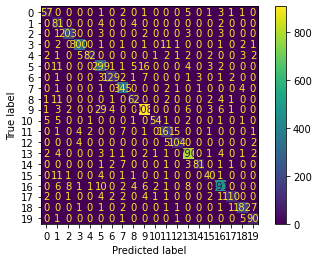

In [300]:
ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
plt.show()

In [301]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_int_cuisine, y_pred))

[[ 57   0   0   0   0   1   0   2   0   1   0   0   0   5   0   1   3   1
    1   0]
 [  0  81   0   0   0   4   0   0   4   0   0   0   0   0   0   0   2   0
    0   0]
 [  0   1 203   0   0   3   0   0   0   2   0   0   0   3   0   0   3   0
    0   0]
 [  0   2   0 300   0   1   0   1   0   1   0  11   1   0   0   0   1   0
    2   1]
 [  2   1   0   5  82   0   0   0   0   0   1   2   1   2   0   2   0   0
    3   2]
 [  0  11   0   0   0 299   1   1   5  16   0   0   0   4   0   3   2   0
    0   0]
 [  0   1   0   0   0   3 129   2   1   7   0   0   0   1   3   0   1   2
    0   0]
 [  0   1   0   0   0   1   0 345   0   0   0   2   1   0   1   0   0   0
    4   0]
 [  1  11   0   0   0   0   1   0  62   0   0   2   0   0   0   2   4   1
    0   0]
 [  1   3   2   0   0  29   4   0   0 908   0   0   0   6   0   3   6   1
    0   0]
 [  5   5   0   0   1   0   0   0   1   0  54   1   0   2   0   0   1   0
    1   0]
 [  0   1   0   4   2   0   0   7   0   1   0 161   5   0   0   1

### Indian Food Data

In [302]:
embedding_layer = Embedding(vocab_size_indian, EMBEDDING_DIM, weights=[embedding_matrix_indian], input_length=MAX_LENGTH_I, trainable=False)

In [303]:
model_CNN = CNNHyperModel(embedding_layer, 2)

In [304]:
model_indian = model_CNN.build(0)

In [305]:
model_indian.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 12, 100)           31400     
                                                                 
 conv1d_19 (Conv1D)          (None, 7, 128)            76928     
                                                                 
 dropout_14 (Dropout)        (None, 7, 128)            0         
                                                                 
 global_max_pooling1d_20 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_63 (Dense)            (None, 128)               16512     
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                     

In [309]:
history_fine = model_indian.fit(X_train_indian_padded,y_train_indian,validation_data=(X_valid_indian_padded,y_valid_indian), epochs=200) 

Epoch 1/200
7/7 [==============================] - 0s 38ms/step - loss: 0.3717 - accuracy: 0.8775 - val_loss: 0.3637 - val_accuracy: 0.8906
Epoch 2/200
7/7 [==============================] - 0s 30ms/step - loss: 0.3708 - accuracy: 0.8775 - val_loss: 0.3632 - val_accuracy: 0.8906
Epoch 3/200
7/7 [==============================] - 0s 26ms/step - loss: 0.3718 - accuracy: 0.8775 - val_loss: 0.3636 - val_accuracy: 0.8906
Epoch 4/200
7/7 [==============================] - 0s 32ms/step - loss: 0.3717 - accuracy: 0.8775 - val_loss: 0.3629 - val_accuracy: 0.8906
Epoch 5/200
7/7 [==============================] - 0s 30ms/step - loss: 0.3710 - accuracy: 0.8775 - val_loss: 0.3620 - val_accuracy: 0.8906
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 0.3711 - accuracy: 0.8775 - val_loss: 0.3610 - val_accuracy: 0.8906
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 0.3716 - accuracy: 0.8775 - val_loss: 0.3612 - val_accuracy: 0.8906
Epoch 8/200
7/7 [===

In [310]:
target_names = pd.Categorical(df_indian['diet']).categories

In [311]:
y_prob = model_indian.predict(X_test_indian_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_indian,y_pred, target_names=target_names))

                precision    recall  f1-score   support

non vegetarian       0.00      0.00      0.00        15
    vegetarian       0.88      1.00      0.94       112

      accuracy                           0.88       127
     macro avg       0.44      0.50      0.47       127
  weighted avg       0.78      0.88      0.83       127



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [312]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_int_indian, y_pred))

[[  0  15]
 [  0 112]]


# RNN

In [354]:
from keras_tuner import HyperModel

class RNNHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(SimpleRNN(64,return_sequences=True,dropout=0.1, recurrent_dropout=0.1, activation='relu'))
    model.add(SimpleRNN(32,activation='relu'))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(self.output, activation="softmax"))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### Cuisine Classification Data

In [355]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM, weights=[embedding_matrix_cuisine], input_length=MAX_LENGTH_C, trainable=False)

In [356]:
model_RNN = RNNHyperModel(embedding_layer, 20)

In [357]:
model_cuisine = model_RNN.build(0)

In [358]:
model_cuisine.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 50, 100)           215100    
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 50, 64)            10560     
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_77 (Dense)            (None, 32)                1056      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_78 (Dense)            (None, 20)                660       
                                                                 
Total params: 230,480
Trainable params: 15,380
Non-tr

In [359]:
history_fine = model_cuisine.fit(X_train_cuisine_padded,y_train_cuisine,validation_data=(X_valid_cuisine_padded,y_valid_cuisine), epochs=50) 

Epoch 1/50
250/250 [==============================] - 9s 29ms/step - loss: 2.8029 - accuracy: 0.1875 - val_loss: 2.6697 - val_accuracy: 0.1962
Epoch 2/50
250/250 [==============================] - 7s 29ms/step - loss: 2.7046 - accuracy: 0.1895 - val_loss: 2.6333 - val_accuracy: 0.1962
Epoch 3/50
250/250 [==============================] - 8s 33ms/step - loss: 2.6834 - accuracy: 0.1871 - val_loss: 2.6152 - val_accuracy: 0.1962
Epoch 4/50
250/250 [==============================] - 7s 27ms/step - loss: 2.6657 - accuracy: 0.1900 - val_loss: 2.6135 - val_accuracy: 0.1962
Epoch 5/50
250/250 [==============================] - 7s 27ms/step - loss: 2.6617 - accuracy: 0.1896 - val_loss: 2.6111 - val_accuracy: 0.1962
Epoch 6/50
250/250 [==============================] - 7s 27ms/step - loss: 2.6591 - accuracy: 0.1893 - val_loss: 2.6156 - val_accuracy: 0.1962
Epoch 7/50
250/250 [==============================] - 7s 27ms/step - loss: 2.6545 - accuracy: 0.1921 - val_loss: 2.6073 - val_accuracy: 0.1962

KeyboardInterrupt: ignored

In [ ]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [ ]:
y_prob = model_cuisine.predict(X_test_cuisine_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names))

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_int_cuisine, y_pred))

### Indian Food Data

In [ ]:
embedding_layer = Embedding(vocab_size_indian, EMBEDDING_DIM, weights=[embedding_matrix_indian], input_length=MAX_LENGTH_I, trainable=False)

In [ ]:
model_CNN = CNNHyperModel(embedding_layer, 2)

In [ ]:
model_indian = model_CNN.build(0)

In [ ]:
model_indian.summary()

In [ ]:
history_fine = model_indian.fit(X_train_indian_padded,y_train_indian,validation_data=(X_valid_indian_padded,y_valid_indian), epochs=200) 

In [ ]:
target_names = pd.Categorical(df_indian['diet']).categories

In [ ]:
y_prob = model_indian.predict(X_test_indian_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_indian,y_pred, target_names=target_names))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_int_indian, y_pred))

# LSTM

In [348]:
from keras_tuner import HyperModel

class LSTMHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

In [349]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM, weights=[embedding_matrix_cuisine], input_length=MAX_LENGTH_C, trainable=False)

In [350]:
model_LSTM = LSTMHyperModel(embedding_layer, 20)

In [351]:
model_cuisine = model_LSTM.build(0)

In [ ]:
model_cuisine.summary()

In [ ]:
history_fine = model_cuisine.fit(X_train_cuisine_padded,y_train_cuisine,validation_data=(X_valid_cuisine_padded,y_valid_cuisine), epochs=50) 